<img align="right" src="https://www.nih-cfde.org/wp-content/uploads/2020/11/CFDE_logo-color-web.png" width="200">

# ReproTox chemo-centric analytics and scientific use cases

In this notebook, we use the machine learning method to identify the drugs associated with birth defects but not coded. This notebook code first searches the Neo4J database to get all drugs. It uses pregnancy category X and D drugs as class 1 and the remaining drugs as class 0. The fingerprints of drugs are used as feature vectors. Many drugs in the KG do not have smiles; we downloaded smiles for those drugs from PubChem.

In [17]:
!pip install rdkit-pypi
import sys,os,json,base64,io,requests,urllib.request
import pandas as pd
from IPython.core.display import display, HTML
from rdkit import Chem,DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
!pip install py2neo
import py2neo
import numpy as np
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Neo4J connection 



In [18]:
dbhost="18.237.14.238"
dbport=7688
dbscheme="bolt"
dbusr="neo4j"
dbpw="M6E-eDY2_oUWVcAhE-ehJwJN"
db = py2neo.GraphService(host=dbhost, port=dbport, scheme=dbscheme, secure=False, user=dbusr, password=dbpw)
grph = db.default_graph

### KG does not have smiles for all drugs. So, use smiles downloaded from PubChem. "smiles.csv" contains PubChem "CID" and "smiles".

In [19]:
# use pubChecm CID as keys and smiles as values.
from urllib.request import urlopen

with urlopen('https://raw.githubusercontent.com/unmtransinfo/reprotox/main/smiles.csv') as response:
  id_smiles_dict = dict(line.decode("utf-8").strip().split(',') for line in response)
  print(id_smiles_dict)


{'137': 'C(CC(=O)O)C(=O)CN', '177': 'CC=O', '178': 'CC(=O)N', '187': 'CC(=O)OCC[N+](C)(C)C', '200': 'C1=NC(=C(N1C2C(C(C(O2)COP(=O)(O)O)O)O)N)C(=O)N', '204': 'C1(C(=O)NC(=O)N1)NC(=O)N', '237': 'CCN(CC)CCCC(C)NC1=C2C=C(C=CC2=NC3=C1C=CC(=C3)Cl)OC', '243': 'C1=CC=C(C=C1)C(=O)O', '244': 'C1=CC=C(C=C1)CO', '264': 'CCCC(=O)O', '298': 'C1=CC(=CC=C1C(C(CO)NC(=O)C(Cl)Cl)O)[N+](=O)[O-]', '299': 'C1(=O)C2(C3(C4(C1(C5(C2(C3(C(C45Cl)(Cl)Cl)Cl)Cl)Cl)Cl)Cl)Cl)Cl', '305': 'C[N+](C)(C)CCO', '323': 'C1=CC=C2C(=C1)C=CC(=O)O2', '338': 'C1=CC=C(C(=C1)C(=O)O)O', '412': 'C1CC(NC1)C2=CN=CC=C2', '444': 'CC(C(=O)C1=CC(=CC=C1)Cl)NC(C)(C)C', '453': 'C(C(C(C(C(CO)O)O)O)O)O', '460': 'COC1=CC=CC=C1O', '476': 'CC(CCOP(=O)(O)O)(CC(=O)O)O', '564': 'C(CCC(=O)O)CCN', '598': 'C(CS(=O)(=O)O)S', '681': 'C1=CC(=C(C=C1CCN)O)O', '753': 'C(C(CO)O)O', '772': 'CC(=O)NC1C(C(C(OC1O)COS(=O)(=O)O)OC2C(C(C(C(O2)C(=O)O)OC3C(C(C(C(O3)CO)OC4C(C(C(C(O4)C(=O)O)O)O)OS(=O)(=O)O)OS(=O)(=O)O)NS(=O)(=O)O)O)OS(=O)(=O)O)O', '774': 'C1=C(NC=N1)CCN'

### Run ML on the drugs data (use fingerprint as feature vector)

In [20]:
# get pregnancy categories X and D drugs from the file.
drugs = pd.read_excel("https://raw.githubusercontent.com/unmtransinfo/reprotox/main/pregnancy_category_D_and_X_v2.xlsx")
drugs = drugs.drop(columns=['category'])

# use PubChem "smiles" if it's missing for a drug
for i, v in enumerate(drugs['smiles']):
  if v is None or 'null' in v:
    try:
      drugs.loc[i, 'smiles'] = id_smiles_dict[drugs['id'][i]]
    except:
      drugs.loc[i, 'smiles'] = 0

# drop all drugs without smiles
print("Before dropping drugs.shape", drugs.shape)
bd_drugs = drugs.loc[drugs['smiles'] != 0]
print("After dropping drugs.shape", bd_drugs.shape)

bd_drugs_smiles = bd_drugs['smiles'].to_numpy()
bd_drugs = pd.DataFrame(bd_drugs)
bd_drugs.head(5)

Before dropping drugs.shape (128, 3)
After dropping drugs.shape (120, 3)


,name,id,smiles
0,fluorouracil,26,FC1=CNC(=O)NC1=O
1,fluorouracil,26,FC1=CNC(=O)NC1=O
2,acetohydroxamic acid,58,CC(=O)NO
3,acitretin,78,COC1=C(C)C(C)=C(\C=C\C(\C)=C\C=C\C(\C)=C\C(O)=...
4,alprazolam,136,CC1=NN=C2CN=C(C3=CC=CC=C3)C3=CC(Cl)=CC=C3N12


Select all drugs from the KG and if "smiles" is missing, use "smiles" from the pubChem file.

In [21]:
# select all drugs
cql = "MATCH (d:Drug) RETURN DISTINCT d.id, d.label, d.smiles;"
results = grph.run(cql)
drugs = results.to_data_frame()

# put smiles if missing
for i, v in enumerate(drugs['d.smiles']):
  if v is None or 'null' in v:
    try:
      drugs.loc[i, 'd.smiles'] = id_smiles_dict[drugs['d.id'][i]]
    except:
      drugs.loc[i, 'd.smiles'] = 0

# drop all drugs without smiles
print("Before dropping drugs.shape", drugs.shape)
all_drugs = drugs.loc[drugs['d.smiles'] != 0]
print("After dropping drugs.shape", all_drugs.shape)
all_drugs = pd.DataFrame(all_drugs)
all_drugs.head(5)

Before dropping drugs.shape (4564, 3)
After dropping drugs.shape (4454, 3)


,d.id,d.label,d.smiles
0,43815,paroxetine,FC1=CC=C(C=C1)[C@@H]1CCNC[C@H]1COC1=CC2=C(OCO2...
1,3878,lamotrigine,NC1=NN=C(C(N)=N1)C1=C(Cl)C(Cl)=CC=C1
2,1775,phenytoin,O=C1NC(=O)C(N1)(C1=CC=CC=C1)C1=CC=CC=C1
4,5281078,mycophenolate-mofetil,COC1=C(C)C2=C(C(=O)OC2)C(O)=C1C\C=C(/C)CCC(=O)...
5,9782,betamethasone,C[C@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@...


**Use pregnancy category X and D drugs to determine the drugs not associated with birth defects. i.e. all drugs - pregnancy category X and D drugs.**


In [22]:
# from all drugs, select drugs that are not in the list of pregnancy category 
# X and D drugs

non_bd_drugs = all_drugs[~all_drugs['d.smiles'].isin(bd_drugs_smiles)]
non_bd_drugs = pd.DataFrame(non_bd_drugs)
print(non_bd_drugs.shape)
non_bd_drugs.head(5)

(4435, 3)


,d.id,d.label,d.smiles
1,3878,lamotrigine,NC1=NN=C(C(N)=N1)C1=C(Cl)C(Cl)=CC=C1
5,9782,betamethasone,C[C@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@...
6,135398658,folic acid,NC1=NC(=O)C2=NC(CNC3=CC=C(C=C3)C(=O)N[C@@H](CC...
7,392622,ritonavir,CC(C)[C@H](NC(=O)N(C)CC1=CSC(=N1)C(C)C)C(=O)N[...
8,135565674,dabigatran etexilate,CCCCCCOC(=O)NC(=N)C1=CC=C(NCC2=NC3=CC(=CC=C3N2...


**Using RDKit, get the fingerprint of drugs**

In [23]:
# get fingerprints for bd drugs
bd_drugs['mol'] = [Chem.MolFromSmiles(smi) for smi in bd_drugs['smiles']]
bd_drugs['fp'] = [Chem.RDKFingerprint(mol) for mol in bd_drugs['mol']]
print(bd_drugs.shape)
bd_drugs.head(5)

(120, 5)


,name,id,smiles,mol,fp
0,fluorouracil,26,FC1=CNC(=O)NC1=O,<rdkit.Chem.rdchem.Mol object at 0x7f2904755ad0>,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,fluorouracil,26,FC1=CNC(=O)NC1=O,<rdkit.Chem.rdchem.Mol object at 0x7f29038c7c10>,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,acetohydroxamic acid,58,CC(=O)NO,<rdkit.Chem.rdchem.Mol object at 0x7f29038acda0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,acitretin,78,COC1=C(C)C(C)=C(\C=C\C(\C)=C\C=C\C(\C)=C\C(O)=...,<rdkit.Chem.rdchem.Mol object at 0x7f29038ac940>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."
4,alprazolam,136,CC1=NN=C2CN=C(C3=CC=CC=C3)C3=CC(Cl)=CC=C3N12,<rdkit.Chem.rdchem.Mol object at 0x7f2903878d00>,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."


In [24]:
# get fingerprints for non_bd drugs
non_bd_drugs['mol'] = [Chem.MolFromSmiles(smi) for smi in non_bd_drugs['d.smiles']]
non_bd_drugs['fp'] = [Chem.RDKFingerprint(mol) for mol in non_bd_drugs['mol']]
print(non_bd_drugs.shape)
non_bd_drugs.head(5)

(4435, 5)


,d.id,d.label,d.smiles,mol,fp
1,3878,lamotrigine,NC1=NN=C(C(N)=N1)C1=C(Cl)C(Cl)=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x7f290372bb70>,"[0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, ..."
5,9782,betamethasone,C[C@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@...,<rdkit.Chem.rdchem.Mol object at 0x7f290373fc60>,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
6,135398658,folic acid,NC1=NC(=O)C2=NC(CNC3=CC=C(C=C3)C(=O)N[C@@H](CC...,<rdkit.Chem.rdchem.Mol object at 0x7f290373fc10>,"[0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, ..."
7,392622,ritonavir,CC(C)[C@H](NC(=O)N(C)CC1=CSC(=N1)C(C)C)C(=O)N[...,<rdkit.Chem.rdchem.Mol object at 0x7f290373fb20>,"[0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."
8,135565674,dabigatran etexilate,CCCCCCOC(=O)NC(=N)C1=CC=C(NCC2=NC3=CC(=CC=C3N2...,<rdkit.Chem.rdchem.Mol object at 0x7f290373f9e0>,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, ..."


**Using fingerprints of drugs, generate feature matrix**

In [25]:
# generate feature vectors for bd drugs
bd_fps = bd_drugs['fp'].values
bd_drug_ids = bd_drugs['id'].values
bd_drug_labels = bd_drugs['name'].values

# convert fp to feature vector
bd_X = np.asarray([list(v.ToBitString()) for v in bd_fps], dtype=np.int8)
print(bd_X.shape)
bd_X[:5]

(120, 2048)


array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 1, 0],
       [1, 0, 1, ..., 1, 1, 1]], dtype=int8)

In [26]:
# generate feature vectors for non_bd drugs
non_bd_fps = non_bd_drugs['fp'].values
non_bd_drug_ids = non_bd_drugs['d.id'].values
non_bd_drug_labels = non_bd_drugs['d.label'].values


# convert fp to feature vector
non_bd_X = np.asarray([list(v.ToBitString()) for v in non_bd_fps], dtype=np.int8)
print(non_bd_X.shape)
non_bd_X[:5]


(4435, 2048)


array([[0, 1, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 0, 1]], dtype=int8)

**Concatenate features of all drugs and assign labels**
- drugs associated with birth defect as 1
- drugs not associated with birth defect as 0

In [27]:
# generate features and labels
X = np.concatenate([bd_X, non_bd_X], axis=0)
print(X.shape)
y = np.concatenate([[1]*bd_X.shape[0], [0]*non_bd_X.shape[0]], axis=0)
print(y, len(y))

# generate list of labels and ids
all_labels = np.concatenate([bd_drug_labels, non_bd_drug_labels], axis=0)
all_ids = np.concatenate([bd_drug_ids, non_bd_drug_ids], axis=0)
print(len(all_labels), len(all_ids))

(4555, 2048)
[1 1 1 ... 0 0 0] 4555
4555 4555


**Run XGBoost with 5-fold CV and return predicted probabilities, labels, and drug_id**

In [28]:
# file to save classification results
fo = open("classification_results.tsv", "w")
hdr = "drug_id" + "\t" + "drug_label" + "\t" + "y_true" + "\t" + "prediction" + "\t" + "iteration" + "\n"
fo.write(hdr)

# XGBoost parameters
tot = Counter(y)
r = tot[0]/tot[1]
print("ratio 0/1: ", r)

xgb_params = {
    'n_jobs': 16,
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'scale_pos_weight': r,
    'random_state': 1001
}

# Run XGBoost with 5-fold CV for n iterations
n_iters = 10
y_true = {}
y_preds = {}
for itr in range(n_iters):
  print("\nRun ML for iteration {0}".format(itr))
  X, y, all_ids, all_labels = shuffle(X, y, all_ids, all_labels, random_state=1001+itr)

  clf = xgb.XGBClassifier(**xgb_params)
  preds = cross_val_predict(clf, X, y, cv=5, method="predict_proba")
  p1 = preds[:, 1]
  print("AUC-ROC: ", roc_auc_score(y, p1))
  print("Average precision score: ", average_precision_score(y, p1))
  
  # save predictions for AUC plot
  y_true[itr] = y
  y_preds[itr] = p1

  # Save classification results in a file
  for i, id in enumerate(all_ids):
    line = str(id) + "\t" + str(all_labels[i]) + "\t" + str(y[i]) + "\t" + str(p1[i]) + "\t" + str(itr) + "\n"
    fo.write(line)
fo.close()

ratio 0/1:  36.958333333333336

Run ML for iteration 0
AUC-ROC:  0.7663115370161593
Average precision score:  0.12875602543131726

Run ML for iteration 1
AUC-ROC:  0.7618724163848177
Average precision score:  0.1230423811469824

Run ML for iteration 2
AUC-ROC:  0.7528363397219091
Average precision score:  0.11744535752679311

Run ML for iteration 3
AUC-ROC:  0.758608605787298
Average precision score:  0.09031581395885983

Run ML for iteration 4
AUC-ROC:  0.7374361142427659
Average precision score:  0.10432298580480769

Run ML for iteration 5
AUC-ROC:  0.7620509207065013
Average precision score:  0.12460599706463416

Run ML for iteration 6
AUC-ROC:  0.7638425403983464
Average precision score:  0.11788761160738144

Run ML for iteration 7
AUC-ROC:  0.7502452085682074
Average precision score:  0.09924828263388233

Run ML for iteration 8
AUC-ROC:  0.7811480646373543
Average precision score:  0.12143819213390344

Run ML for iteration 9
AUC-ROC:  0.7656172491544533
Average precision score:  0

**Generate AUC ROC curve plot**

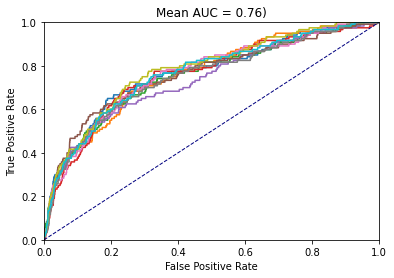

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

# compute sensitivity, specificity for each run
fpr = {}
tpr = {}
roc_auc = []

for i in range(n_iters):
  fpr[i], tpr[i], _ = roc_curve(y_true[i], y_preds[i])
  roc_auc.append(auc(fpr[i], tpr[i]))

# generate plot
plt.figure()
for i in range(n_iters):
  plt.plot(fpr[i], tpr[i])
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean AUC = %0.2f)" % np.mean(roc_auc))
plt.show()
